## Forecasting the Number of Cases of Gonorrhea for the Remaining Months of Year 2024 in the city of Toronto ##



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

### Extracting all the data for Gonorrhea and saving it as a new dataframe ###

In [2]:
data = pd.read_csv('Communicable disease surveillance data 2017-2024.csv')

In [3]:
g_data = data[data['Disease'].str.strip() == 'Gonorrhea']

In [4]:
g_data

,Disease,YTD Cases,January,February,March,April,May,June,July,August,September,October,November,December,Year,MOT
4,Gonorrhea,"7,215",484,433,524,456,599,694,724,697,697,672,680,555,2023,Sexually Transmitted and Bloodborne
78,Gonorrhea,"1,709",667,548,494,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024,Sexually Transmitted and Bloodborne
152,Gonorrhea,"3,627",457,372,298,145,170,260,283,310,333,356,348,295,2020,Sexually Transmitted and Bloodborne
222,Gonorrhea,"4,894",451,323,399,402,368,362,482,443,432,486,413,333,2019,Sexually Transmitted and Bloodborne
291,Gonorrhea,"4,552",309,285,257,310,326,432,447,475,417,461,434,399,2018,Sexually Transmitted and Bloodborne
362,Gonorrhea,"3,320",227,189,236,244,251,279,330,314,336,335,305,274,2017,Sexually Transmitted and Bloodborne
429,Gonorrhea,"3,740",316,273,291,216,196,250,270,344,427,428,429,300,2021,Sexually Transmitted and Bloodborne
499,Gonorrhea,"5,327",321,303,478,440,469,495,466,458,472,465,520,440,2022,Sexually Transmitted and Bloodborne


In [5]:
g_data.isnull().sum()

Disease      0
YTD Cases    0
January      0
February     0
March        0
April        1
May          1
June         1
July         1
August       1
September    1
October      1
November     1
December     1
Year         0
MOT          0
dtype: int64

### Data Cleaning, Preparation, Wrangling, and Manipulation ###

In [6]:
g_data.fillna(0, inplace=True)

In [7]:
g_data_melted = g_data.melt(
    id_vars=['Year', 'Disease', 'YTD Cases', 'MOT'],
    value_vars=['January', 'February', 'March', 'April',
                'May', 'June', 'July', 'August',
                'September', 'October', 'November', 'December'],
    var_name='Month',
    value_name='Cases'
)

### Melting the original dataframe. This process creates two new columns: Month (containing the months of the year) and Cases (containing the number of recorded cases) which will help us to convert this data frame into a time series dataframe.

In [8]:
g_data_melted['Cases'] = g_data_melted['Cases'].astype(str).str.replace(',', '').astype(float)


### We will add a new column Date by converting the Year and Month columns into a single column with a datetime datatype using pd.to_datetime. This conversion is achieved by combining the Year and Month columns into a string format and then parsing it as a date.

In [9]:
g_data_melted['Date'] = pd.to_datetime(g_data_melted['Year'].astype(str) + '-' + g_data_melted['Month'], format='%Y-%B')


### Sorting the values of data so we can see the time-series clearly

In [10]:
g_data_melted = g_data_melted.sort_values('Date')


### Extracting Date and Cases columns from the dataframe and saving it to new dataframe. Now we have a time-series dataframe which is ready for analysis and forecasting

In [11]:
g_time_series = g_data_melted[['Date', 'Cases']].set_index('Date').asfreq('MS')


### We need to drop the data after March 2024 because these entries only contain 0 values. This is because our dataset only includes cases from January 2017 to March 2024.

In [12]:
g_time_series = g_time_series[g_time_series.index < '2024-04-01']


In [13]:
decomposition_g = seasonal_decompose(g_time_series.dropna(), model='additive', period=12)


### Now, we will perform decomposition on the time series because it helps us isolate and analyze the underlying components such as trend, seasonality, and residuals. This process enhances our understanding of the data's structure and improves our ability to capture the time-series patterns, leading to more accurate forecasting models. By decomposing the time series, we can ensure that our model effectively captures and utilizes the inherent characteristics of the data.

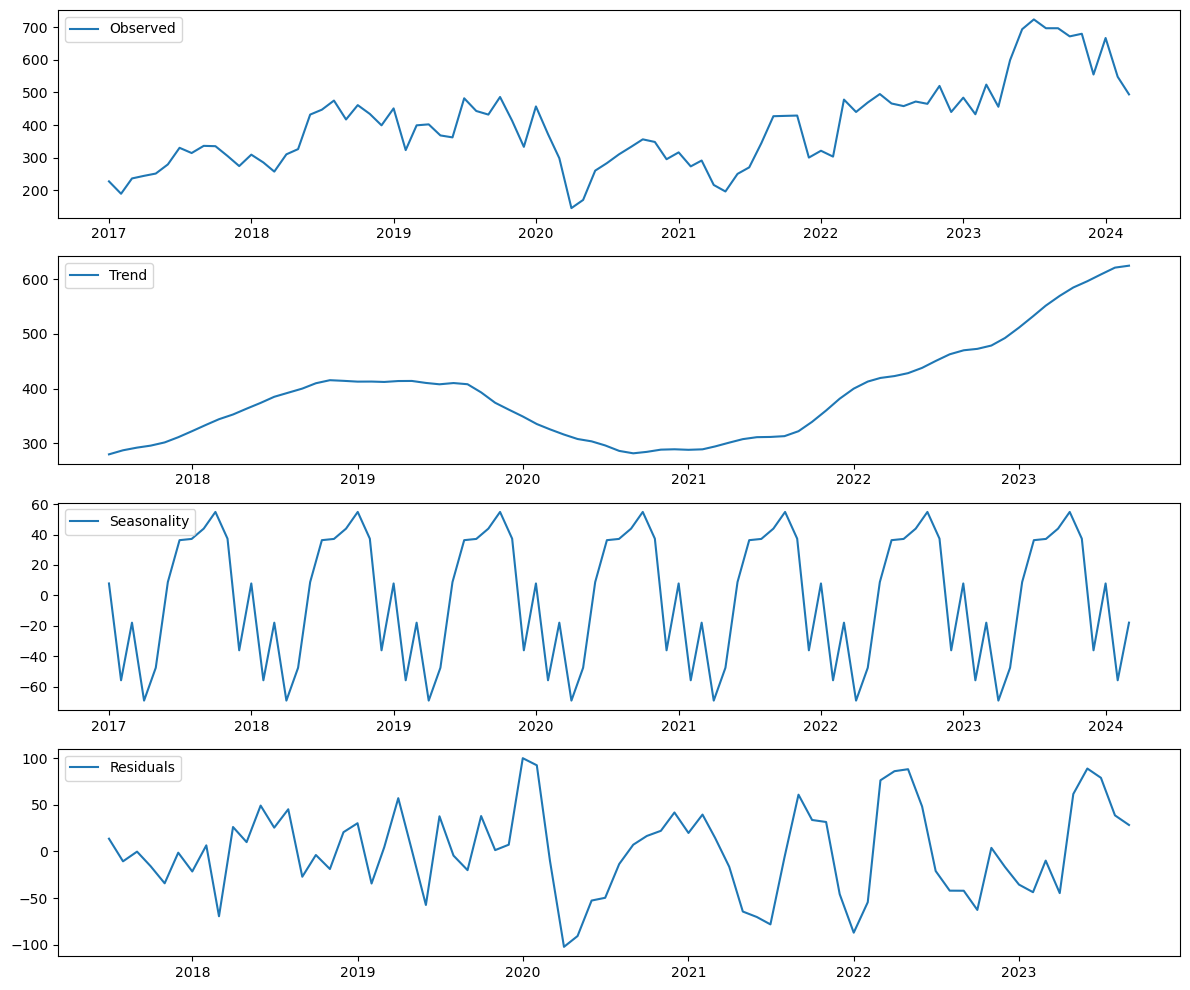

In [14]:
plt.figure(figsize=(12, 10))
plt.subplot(411)
plt.plot(decomposition_g.observed, label='Observed')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decomposition_g.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decomposition_g.seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decomposition_g.resid, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### The decomposition shows that the observed data for gonorrhea cases exhibit clear trend, seasonality, and residual components. The trend component indicates a general increase in cases from 2021 onwards, following a slight decline from 2019 to 2020. The seasonal component highlights consistent, repeating patterns, with regular fluctuations occurring throughout each year, suggesting a strong seasonal influence on gonorrhea case numbers. The residuals capture the irregular variations not explained by the trend or seasonality, including notable deviations around 2020. This insight will be useful for understanding the dynamics of gonorrhea cases and will be used for setting hyperparameters in our forecasting models to improve accuracy and reliability.

###   


### For this project, we will be training our dataframe using three models: Exponential Smoothing, ARIMA, and SARIMA. Now, let's split the data into training and testing sets to evaluate the performance of these three models and determine which model best captures and forecasts the number of cases for this dataframe.

In [15]:
train_end_g = '2023-12-01'
test_start_g = '2024-01-01'

train_data_g = g_time_series[:train_end_g]
test_data_g = g_time_series[test_start_g:]

### We will be performing a grid search to find the best parameters for our ARIMA and SARIMA models. Initially, we used the original ACF and PACF plots to estimate the parameters, but they did not produce the optimal results. To ensure better performance, we systematically explored a range of potential parameter values using a comprehensive grid search. This involved training and evaluating models for each parameter combination to identify the most effective settings for accurate and reliable forecasts.

In [16]:
import itertools
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

best_aic = float("inf")
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(train_data_g,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
        except:
            continue

print(f'Best SARIMA params: {best_params}')
print(f'Best seasonal params: {best_seasonal_params}')

Best SARIMA params: (2, 2, 2)
Best seasonal params: (0, 2, 2, 12)


In [17]:
p = d = q = range(0, 4)
param_grid = list(itertools.product(p, d, q))

best_rmse = float("inf")
best_params = None
results = []

for param in param_grid:
    try:
        model = ARIMA(train_data_g, order=param)
        fit = model.fit()
        forecast = fit.forecast(steps=len(test_data_g))
        forecast = pd.Series(forecast, index=test_data_g.index)
        rmse = mean_squared_error(test_data_g, forecast, squared=False)
        results.append((param, rmse))
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = param
            
    except Exception as e:
        print(f"Failed for parameters: {param}")
        print(str(e))
        continue

print("Best RMSE: ", best_rmse)
print("Best Parameters: ", best_params)

Best RMSE:  64.77237911289515
Best Parameters:  (2, 1, 3)


### Take note that the hyperparemetes that we are passing to the models are from the insights that we gained earlier in our decomposition and grid search.

In [18]:
exp_smoothing_model_g = ExponentialSmoothing(train_data_g, trend='mul', seasonal='add', seasonal_periods=24)
exp_smoothing_fit_g = exp_smoothing_model_g.fit()

In [19]:
test_forecast_exp_smoothing_g = exp_smoothing_fit_g.predict(start=test_data_g.index[0], end=test_data_g.index[-1])

mae_exp_g= mean_absolute_error(test_data_g, test_forecast_exp_smoothing_g)
mse_exp_g = mean_squared_error(test_data_g, test_forecast_exp_smoothing_g)
rmse_exp_g = np.sqrt(mse_exp_g)


In [20]:
arima_model_g = ARIMA(train_data_g, order=(1, 1, 1))
arima_fit_g = arima_model_g.fit()

test_forecast_arima_g = arima_fit_g.predict(start=test_data_g.index[0], end=test_data_g.index[-1], typ='levels')

mae_arima_g = mean_absolute_error(test_data_g, test_forecast_arima_g)
mse_arima_g = mean_squared_error(test_data_g, test_forecast_arima_g)
rmse_arima_g = np.sqrt(mse_arima_g)


In [21]:
sarima_model_g = SARIMAX(train_data_g,order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit_g = sarima_model_g.fit(disp=False)

test_forecast_sarima_g = sarima_fit_g.predict(start=test_data_g.index[0], end=test_data_g.index[-1], typ='levels')

mae_sarima_g = mean_absolute_error(test_data_g, test_forecast_sarima_g)
mse_sarima_g = mean_squared_error(test_data_g, test_forecast_sarima_g)
rmse_sarima_g = np.sqrt(mse_sarima_g)

In [22]:
metrics_g = {
    'Model': ['Exponential Smoothing', 'ARIMA', 'SARIMA'],
    'MAE': [mae_exp_g, mae_arima_g, mae_sarima_g],
    'MSE': [mse_exp_g, mse_arima_g, mse_sarima_g],
    'RMSE': [rmse_exp_g, rmse_arima_g, rmse_sarima_g]
}

metrics_df_g = pd.DataFrame(metrics_g)
metrics_df_g

,Model,MAE,MSE,RMSE
0,Exponential Smoothing,48.733989,3083.336655,55.527801
1,ARIMA,60.000266,4997.049005,70.689808
2,SARIMA,57.574485,5832.826313,76.372942


In [23]:
print(g_time_series.min())
print(g_time_series.max())

Cases    145.0
dtype: float64
Cases    724.0
dtype: float64


### The evaluation of the models for predicting gonorrhea cases on the test set yields the following metrics:
Exponential Smoothing: MAE (Mean Absolute Error) is 48.73, MSE (Mean Squared Error) is 3083.34, and RMSE (Root Mean Squared Error) is 55.53. These metrics indicate the average magnitude of the errors in the model's predictions, with the RMSE providing a measure of how much prediction errors deviate from the actual values.

ARIMA: MAE is 60, MSE is 4997.05, and RMSE is 70.69. This model's predictions have higher errors compared to Exponential Smoothing, with the RMSE indicating a less accurate fit.

SARIMA: MAE is 57.57, MSE is 5832.82, and RMSE is 76.37. This model shows the highest error metrics, making it the least accurate among the three.

Thus, the Exponential Smoothing model's predictions are, on average, off by approximately 55.53 cases from the actual values. Considering that the minimum value in the dataset is 145 cases and the maximum value is 724 cases, the RMSE of 55.53 is relatively small compared to the range. This suggests that the Exponential Smoothing model's prediction errors are minor relative to the overall variability in the data, effectively capturing the trends and seasonal patterns of gonorrhea cases.

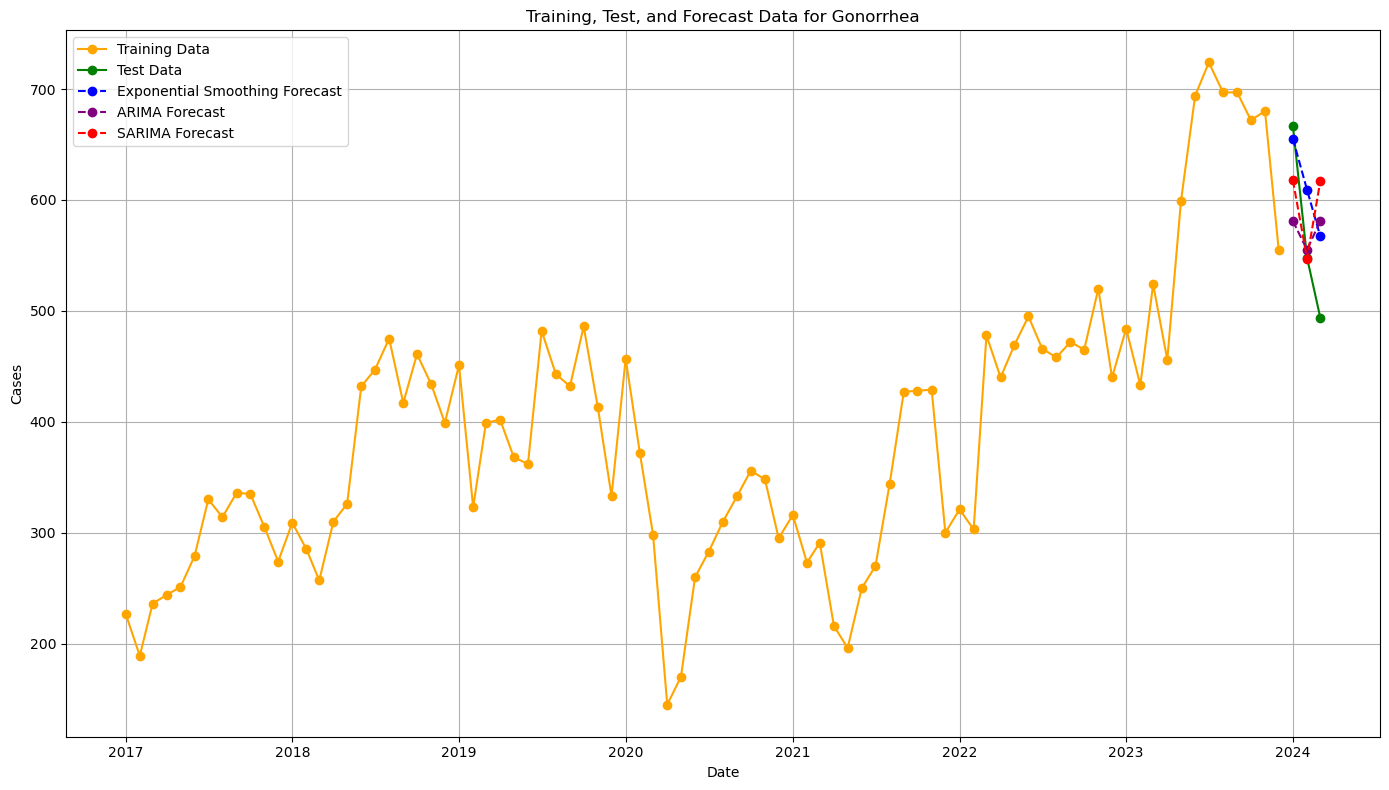

In [24]:
plt.figure(figsize=(14, 8))
plt.plot(train_data_g.index, train_data_g['Cases'], label='Training Data', color='orange', marker='o')
plt.plot(test_data_g.index, test_data_g['Cases'], label='Test Data', color='green', marker='o')
plt.plot(test_forecast_exp_smoothing_g.index, test_forecast_exp_smoothing_g, label='Exponential Smoothing Forecast', color='blue', linestyle='--', marker='o')
plt.plot(test_forecast_arima_g.index, test_forecast_arima_g, label='ARIMA Forecast', color='purple', linestyle='--', marker='o')
plt.plot(test_forecast_sarima_g.index, test_forecast_sarima_g, label='SARIMA Forecast', color='red', linestyle='--', marker='o')
plt.title('Training, Test, and Forecast Data for Gonorrhea')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph shows the performance of the Exponential Smoothing, ARIMA, and SARIMA models in forecasting gonorrhea cases. The Exponential Smoothing model (blue) aligns most closely with the test data (green), indicating its superior accuracy among the three models. ARIMA (purple) and SARIMA (red) forecasts exhibit higher deviations from the actual test data, with SARIMA showing the least accuracy. This visual analysis confirms the numerical evaluation, highlighting Exponential Smoothing as the most reliable model for predicting gonorrhea cases.

### Now that we have figured out which model performs best, we can proceed with Exponential Smoothing for forecasting the number of cases, as it best captures the time series patterns and shows the closest alignment with the test data and the lowest prediction errors compared to ARIMA and SARIMA.

In [25]:
exp_smoothing_model_full_g = ExponentialSmoothing(g_time_series.dropna(),  trend='mul', seasonal='add', seasonal_periods=24)
exp_smoothing_fit_full_g = exp_smoothing_model_full_g.fit()

extended_forecast_series = exp_smoothing_fit_full_g.predict(start='2024-04-01', end='2025-07-01')


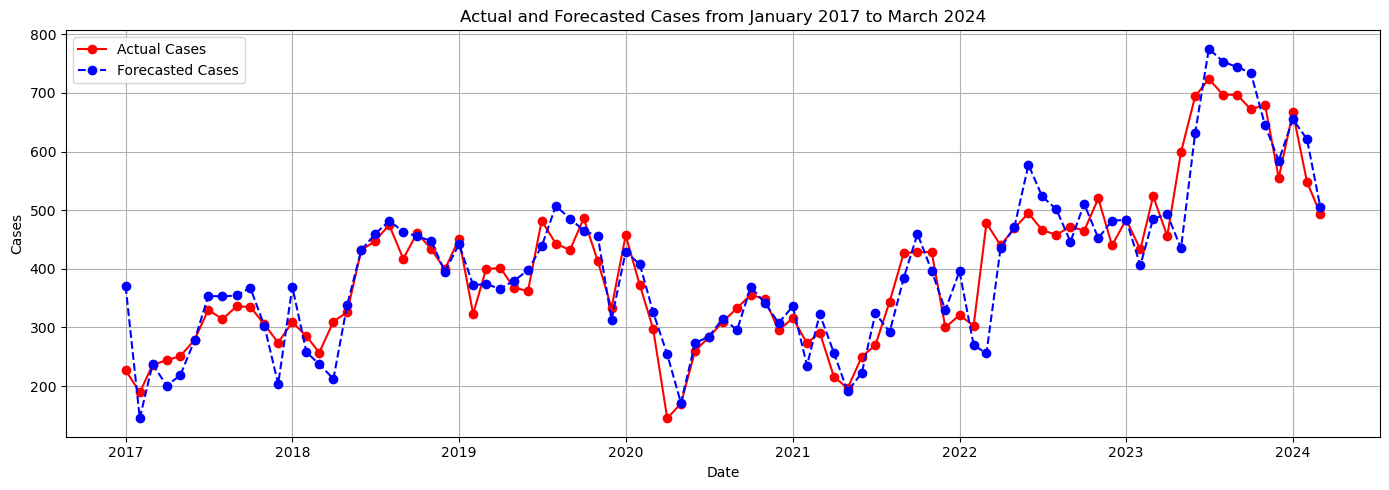

In [26]:
plt.figure(figsize=(14, 5))


plt.plot(g_time_series.index,g_time_series['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(exp_smoothing_fit_full_g.fittedvalues.index, exp_smoothing_fit_full_g.fittedvalues, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.title('Actual and Forecasted Cases from January 2017 to March 2024')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### The graph shows us that the forecasted cases (blue) closely follow the actual cases (red) for gonorrhea from January 2017 to March 2024. The forecast effectively captures the trends and seasonal variations in the data, demonstrating the model's capability to predict future cases with a high degree of accuracy. While there are some deviations, particularly during peak periods, the overall alignment between the forecasted and actual cases suggests that the model reliably anticipates the fluctuations and patterns in gonorrhea case numbers. This close alignment underscores the model's effectiveness in producing realistic and reliable forecasts.

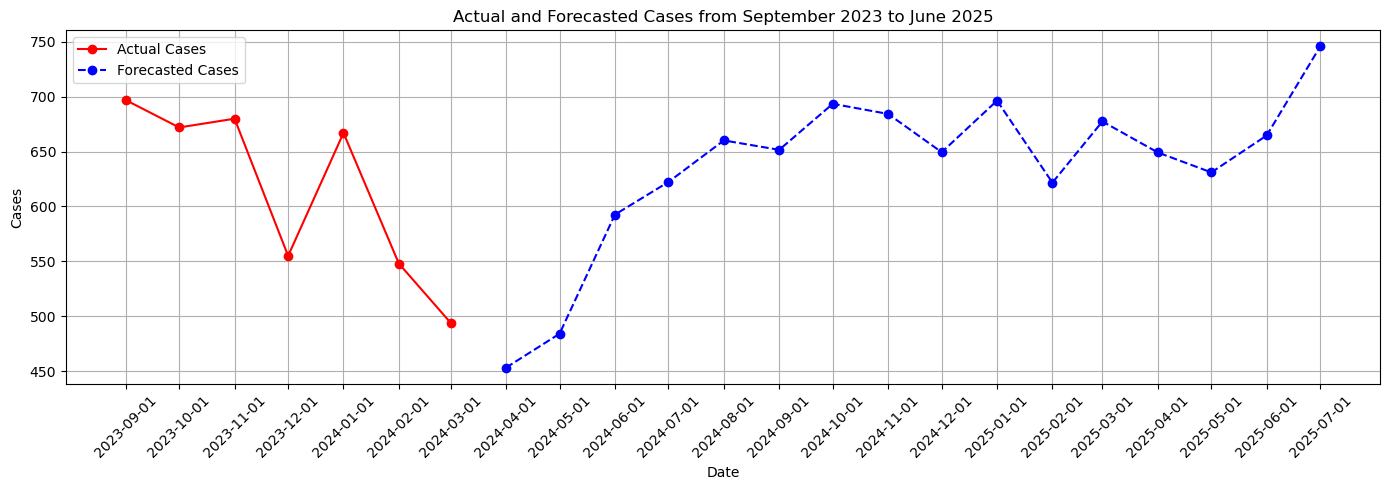

In [27]:
plt.figure(figsize=(14, 5))

actual_data_extended = g_time_series['2023-09-01':'2024-03-01']
plt.plot(actual_data_extended.index, actual_data_extended['Cases'], label='Actual Cases', color='red', marker='o')

plt.plot(extended_forecast_series.index, extended_forecast_series, label='Forecasted Cases', color='blue', linestyle='--', marker='o')

plt.xticks(pd.date_range(start='2023-09-01', end='2025-07-01', freq='MS'), rotation=45)
plt.title('Actual and Forecasted Cases from September 2023 to June 2025')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### The graph shows that the forecasted cases (blue) capture and continue the downward trend observed in the actual cases (red) up to March 2024. After this period, the forecast predicts a gradual increase starting around April 2024, peaking in mid-2024, and then fluctuating with a general upward trend towards mid-2025. This suggests that the model anticipates a seasonal pattern with periodic increases in case numbers. The close alignment between the forecasted and actual cases indicates the model's reliability in capturing the overall trend and seasonal fluctuations in gonorrhea cases, providing confidence in its future predictions.

In [28]:
forecast_df = pd.DataFrame({
    'Date': extended_forecast_series.index,
    'Forecasted Cases': extended_forecast_series.values
})

forecast_df

,Date,Forecasted Cases
0,2024-04-01,453.126334
1,2024-05-01,484.019868
2,2024-06-01,592.576061
3,2024-07-01,622.357029
4,2024-08-01,660.187344
5,2024-09-01,651.618078
6,2024-10-01,693.548727
7,2024-11-01,684.327362
8,2024-12-01,649.457536
9,2025-01-01,696.434329


In [29]:
actual_data_extended

,Cases
Date,
2023-09-01,697.0
2023-10-01,672.0
2023-11-01,680.0
2023-12-01,555.0
2024-01-01,667.0
2024-02-01,548.0
2024-03-01,494.0


### We can see that the forecasted values for gonorrhea cases are not significantly different from the most recent actual values. For instance, the actual case numbers for March 2024 are 494, and the forecasted case numbers for April 2024 are 453. This close alignment between forecasted and actual data demonstrates that the model is capable of producing realistic and reliable forecasts. This consistency enhances our confidence in the model's ability to accurately predict future trends and seasonal variations in gonorrhea cases.

Rolling Forecast RMSE: 58.214816160512285


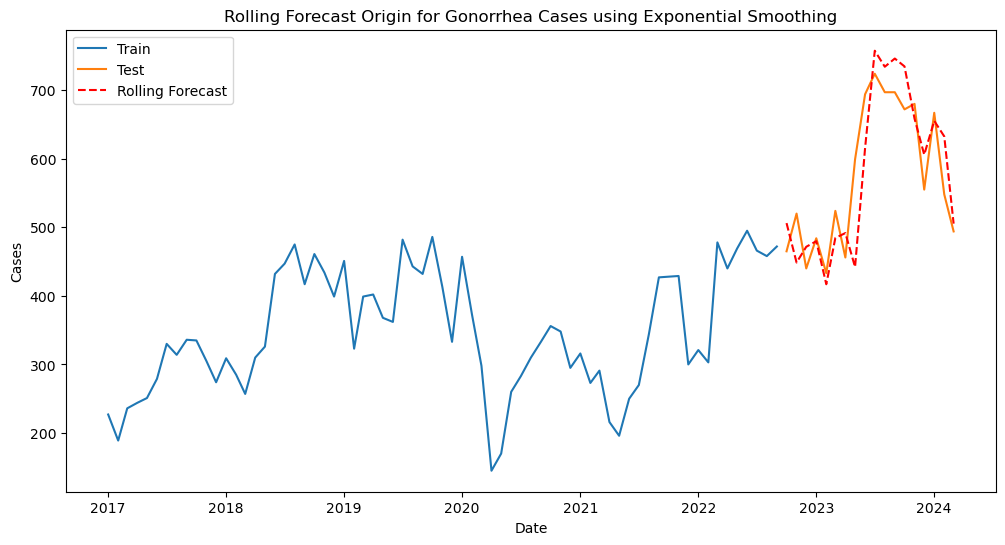

In [30]:
split_point = int(len(g_time_series) * 0.8)
train, test = g_time_series[:split_point], g_time_series[split_point:]

history = train.copy()

predictions = []
for t in range(len(test)):
    model = ExponentialSmoothing(history['Cases'], trend='mul', seasonal='add', seasonal_periods=24)
    model_fit = model.fit()
    output = model_fit.forecast(1)
    yhat = output[0]
    predictions.append(yhat)
    obs = test['Cases'].iloc[t]
    history = pd.concat([history, test.iloc[[t]]])

rmse = np.sqrt(mean_squared_error(test['Cases'], predictions))
print(f'Rolling Forecast RMSE: {rmse}')

test['Predictions'] = predictions
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Cases'], label='Train')
plt.plot(test.index, test['Cases'], label='Test')
plt.plot(test.index, test['Predictions'], label='Rolling Forecast', color='red', linestyle='--')
plt.title('Rolling Forecast Origin for Gonorrhea Cases using Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.legend()
plt.show()

### The graph shows that the Exponential Smoothing model performs well in predicting future trends for gonorrhea cases, as evidenced by the close alignment between the rolling forecast and the test data. The model effectively captures the upward trend observed in the test data and provides realistic projections. The rolling forecast validation further supports the model's effectiveness, with a rolling forecast RMSE of 58.21, indicating strong predictive performance over time. This close alignment suggests that the model can be relied upon for accurate future predictions, making it a valuable tool for public health planning and intervention.

### Conclusion:
This model's forecast demonstrates its reliability and accuracy in predicting future trends for gonorrhea cases by closely aligning forecasted values with the most recent actual values. For example, the actual case numbers for March 2024 are 494, and the forecasted case numbers for April 2024 are 453, indicating a close match. This consistency provides confidence in the model's capability to produce realistic and reliable forecasts. The rolling forecast validation further supports the model's effectiveness, with a rolling forecast RMSE of 58.21, indicating strong predictive performance over time.

By effectively capturing these trends and accounting for significant fluctuations, the model provides realistic forecasts that can be invaluable for public health planning. Public health officials can leverage these predictions to allocate resources efficiently, anticipate potential outbreaks, and implement timely interventions. They can strengthen preventive measures during anticipated peak periods, educate the public on how to prevent contracting the disease, promote safe practices, and research the most vulnerable age groups. This proactive approach, guided by reliable forecasting, can significantly mitigate the impact of gonorrhea, ultimately aiming to prevent outbreaks and achieve the long-term goal of reaching 0 cases per month.